In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 200)

In [2]:
df = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")

df.sample(n=10, random_state=1) # random_state provides reproducibility :)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
6087,464509,Male,Yes,53,Yes,Artist,0.0,High,4.0,Cat_6,C
6723,467663,Male,Yes,31,No,Doctor,NaN,Average,2.0,Cat_6,D
130,465215,Male,Yes,39,Yes,Executive,9.0,High,5.0,Cat_2,A
3792,464782,Male,Yes,35,No,Marketing,0.0,Low,3.0,Cat_4,D
4444,465124,Female,Yes,29,Yes,Healthcare,6.0,Average,2.0,Cat_6,A
5685,466623,Male,Yes,56,NaN,Entertainment,4.0,Average,4.0,Cat_3,C
103,463426,Male,Yes,38,No,Executive,0.0,High,5.0,Cat_6,A
3988,460413,Female,No,39,Yes,Artist,7.0,Low,1.0,Cat_6,B
2567,463439,Male,Yes,42,Yes,Artist,9.0,Average,3.0,Cat_6,B
3593,460147,Male,Yes,67,Yes,Entertainment,1.0,Average,3.0,Cat_6,C


In [3]:
values_to_fill = {
    'Ever_Married': 'Rather not disclose', 
    'Graduated': 'Yes', 
    'Profession': 'Unemployed',
    'Work_Experience': 0,
    'Family_Size': 1
}

cleaned_df = df.fillna(value=values_to_fill).drop('Var_1', axis=1)
cleaned_test_df = df_test.fillna(value=values_to_fill).drop('Var_1', axis=1)
# Sanity check
cleaned_test_df.isnull().values.any()
features = cleaned_df.iloc[:, 1:-1] 
features["Work_Experience_to_Age_Ratio"] = features["Work_Experience"] / features["Age"]

labels = cleaned_df.iloc[:, -1]

features_test = cleaned_test_df.iloc[:, 1:-1] 
features_test["Work_Experience_to_Age_Ratio"] = features_test["Work_Experience"] / features_test["Age"]

labels_test = cleaned_test_df.iloc[:, -1]

from sklearn.preprocessing import LabelEncoder

## Helper function to map encoded label classes
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder

    Arguments:
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

## In-place transformation towards features:
for col in ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']:
    encoder = LabelEncoder()
    features[col] = encoder.fit_transform(features[col])
    print("For column:", col)
    print(get_integer_mapping(encoder))

## We do the same in-place transformation towards test features:
for col in ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score']:
    encoder = LabelEncoder()
    features_test[col] = encoder.fit_transform(features_test[col])
    ## print("For column: ", col)
    ## print(get_integer_mapping(encoder))

from keras.utils import np_utils

new_encoder = LabelEncoder()
new_encoder.fit(labels)
new_encoder.fit(labels_test)
labels = new_encoder.transform(labels)
labels_test = new_encoder.transform(labels_test)
labels = np_utils.to_categorical(labels)
labels_test = np_utils.to_categorical(labels_test)
print(labels)

For column: Gender
{'Female': 0, 'Male': 1}
For column: Ever_Married
{'No': 0, 'Rather not disclose': 1, 'Yes': 2}
For column: Graduated
{'No': 0, 'Yes': 1}
For column: Profession
{'Artist': 0, 'Doctor': 1, 'Engineer': 2, 'Entertainment': 3, 'Executive': 4, 'Healthcare': 5, 'Homemaker': 6, 'Lawyer': 7, 'Marketing': 8, 'Unemployed': 9}
For column: Spending_Score
{'Average': 0, 'High': 1, 'Low': 2}
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [4]:
features.shape

(8068, 9)

In [5]:
features_test.shape

(2627, 9)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=20)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
  "model_checkpoints", monitor="val_auc", verbose=1, save_best_only=True, mode="max")

input_dim = len(features.columns) - 1
model = Sequential()
model.add(tf.keras.Input(shape=(features.shape[1],)))
model.add(Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.005)

model.compile(loss = 'categorical_crossentropy' , optimizer = opt, metrics = [
      tf.keras.metrics.AUC(),
      tf.keras.metrics.Precision()
      ] )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2

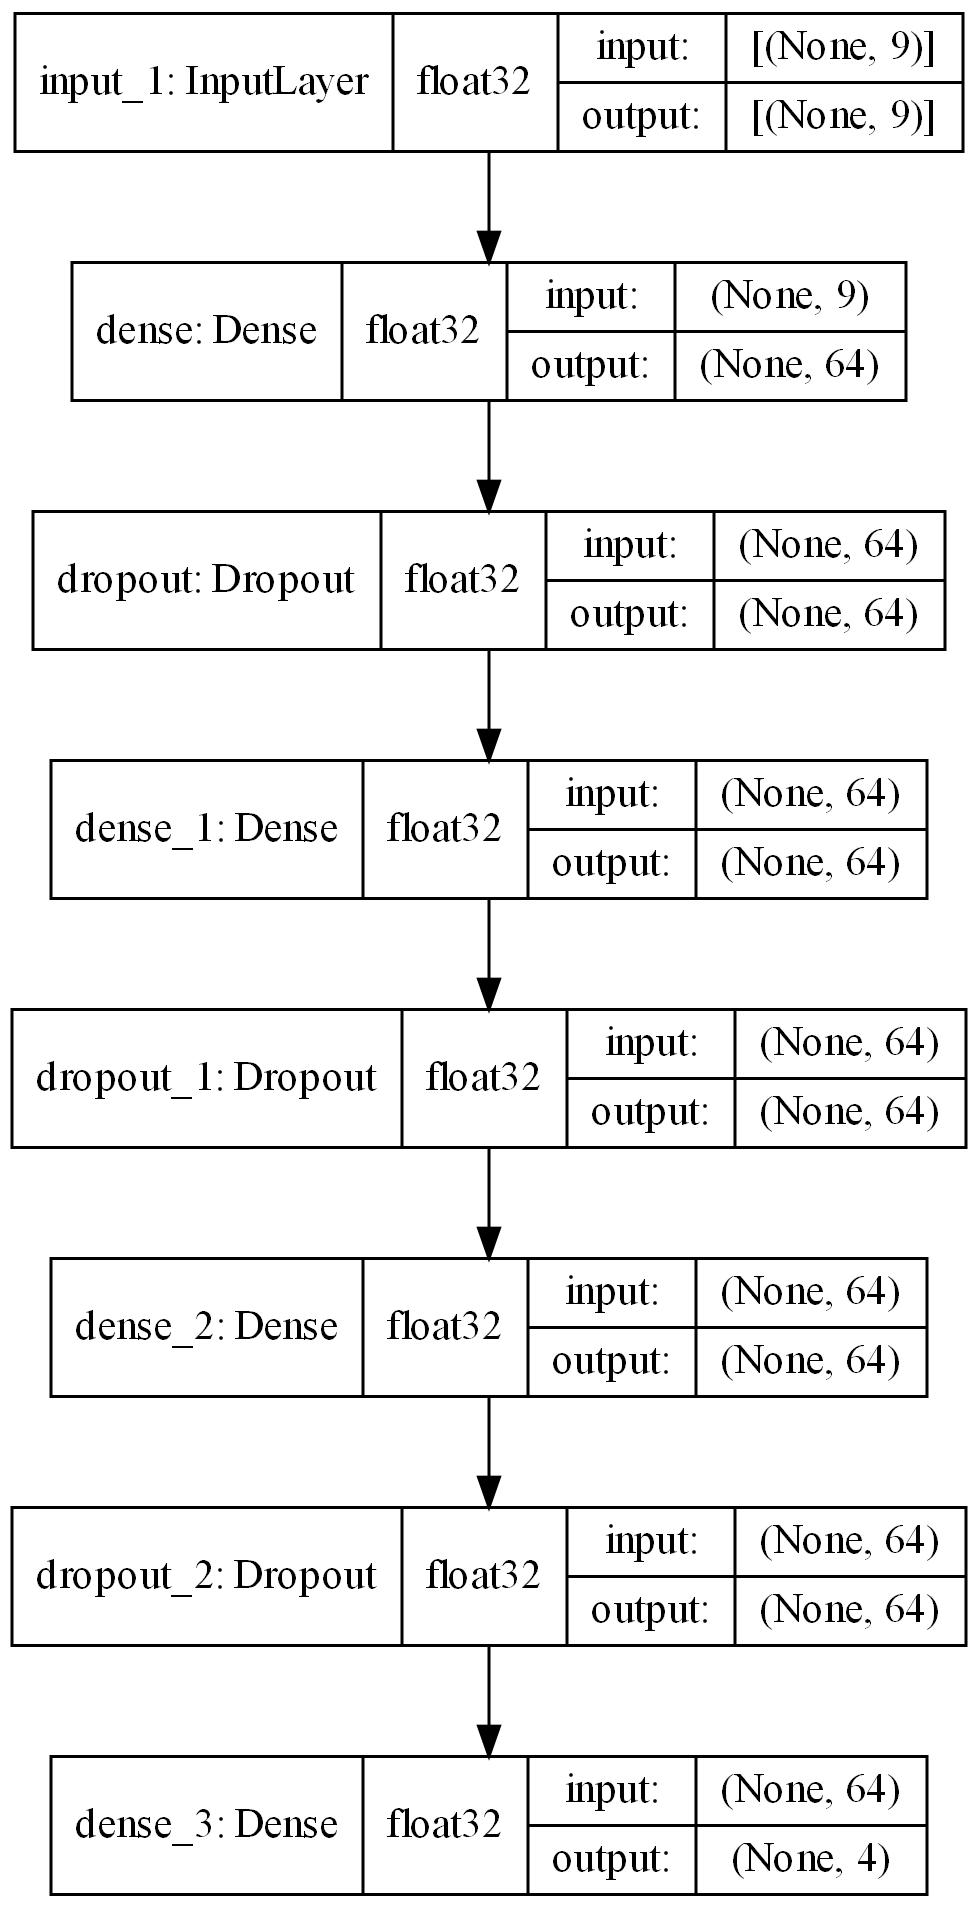

In [7]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=216
)

In [8]:
model.fit(features, labels, epochs = 100, batch_size = 4, validation_split=0.2, callbacks = [checkpoint, es])

Epoch 1/100
1614/1614 [==============================] - 4s 2ms/step - loss: 1.3088 - auc: 0.6668 - precision: 0.6096 - val_loss: 1.2608 - val_auc: 0.6836 - val_precision: 0.9041

Epoch 00001: val_auc improved from -inf to 0.68359, saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets
Epoch 2/100
1614/1614 [==============================] - 2s 1ms/step - loss: 1.2251 - auc: 0.7133 - precision: 0.6493 - val_loss: 1.1515 - val_auc: 0.7520 - val_precision: 0.7367

Epoch 00002: val_auc improved from 0.68359 to 0.75201, saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets
Epoch 3/100
1614/1614 [==============================] - 2s 1ms/step - loss: 1.2071 - auc: 0.7225 - precision: 0.6698 - val_loss: 1.2124 - val_auc: 0.7100 - val_precision: 0.7525

Epoch 00003: val_auc did not improve from 0.75201
Epoch 4/100
1614/1614 [==============================] - 2s 1ms/step - loss: 1.1941 - auc: 0.7326 - precision: 0.67


Epoch 00034: val_auc improved from 0.75769 to 0.75840, saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets
Epoch 35/100
1614/1614 [==============================] - 2s 1ms/step - loss: 1.1992 - auc: 0.7257 - precision: 0.7092 - val_loss: 1.1714 - val_auc: 0.7408 - val_precision: 0.7736

Epoch 00035: val_auc did not improve from 0.75840
Epoch 36/100
1614/1614 [==============================] - 2s 1ms/step - loss: 1.1827 - auc: 0.7347 - precision: 0.7093 - val_loss: 1.1436 - val_auc: 0.7501 - val_precision: 0.7332

Epoch 00036: val_auc did not improve from 0.75840
Epoch 37/100
1614/1614 [==============================] - 2s 1ms/step - loss: 1.1930 - auc: 0.7282 - precision: 0.7174 - val_loss: 1.1898 - val_auc: 0.7264 - val_precision: 0.8629

Epoch 00037: val_auc did not improve from 0.75840
Epoch 38/100
1614/1614 [==============================] - 2s 1ms/step - loss: 1.1938 - auc: 0.7284 - precision: 0.6887 - val_loss: 1.1703 - val_auc: 0.7455 -

In [9]:
scores = model.evaluate(
    features_test, labels_test, batch_size=1, verbose=1, sample_weight=None, steps=None,
    callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False,
    return_dict=False
)
print("------------------ EVALUATION FINISHED! ------------------".center(115))
for i in range(len(scores)):
    print("%s: %.2f%%" % (model.metrics_names[i], scores[i]*100))

2627/2627 [==============================] - 4s 1ms/step - loss: 1.3890 - auc: 0.6006 - precision: 0.4967A: 0s - loss: 1.3853 - auc: 0.6004 - precis - ETA: 0s - loss: 1.3888 - auc: 0.6013 - precision
                             ------------------ EVALUATION FINISHED! ------------------                            
loss: 138.90%
auc: 60.06%
precision: 49.67%


[0 0 0 ... 0 0 0] [1 0 0 ... 2 2 0]
ROC AUC score: 0.5496328298958731


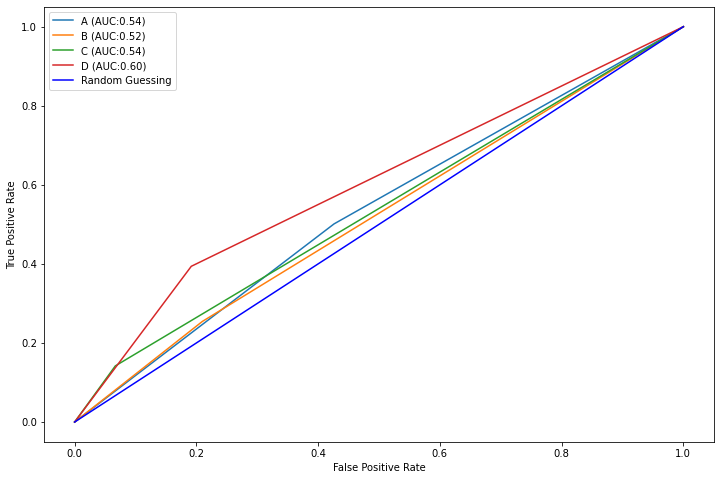

In [10]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

ypred = model.predict(features_test)
ypred = ypred.argmax(axis=-1)

ytrain = labels_test.argmax(axis=-1)
print(ypred, ytrain)

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(['A','B','C','D']):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(ytrain, ypred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig("auc.png")
plt.show()
